## Actor-critic based algorithms

In [148]:
# Gym stuff
import gym
import gym_anytrading

# RL 
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C, PPO2
from stable_baselines.common.callbacks import EvalCallback
from stable_baselines.common.policies import MlpPolicy

import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [140]:
def draw_fig(model):
    env = gym.make('stocks-v0', df=df, frame_bound=(1000,1100), window_size=10)
    obs = env.reset()
    while True:
        obs = obs[np.newaxis, ...]
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        if done:
            print('info', info)
            break

    plt.figure(figsize=(15,6))
    plt.cla()
    env.render_all()
    plt.show()

In [141]:
df = pd.read_hdf('data/data.h5', key='yfinance')
df = df.stack().groupby(['Symbols', 'Date']).mean()

first_df = df.loc['ABBV']

In [142]:
frame_bound = (10,1000)
env_maker = lambda: gym.make('stocks-v0', df=first_df, frame_bound=frame_bound, window_size=10)
env = DummyVecEnv([env_maker])

### PPO

In [173]:
def train_PPO(env_train, model_name, timesteps=50000):
    """PPO model"""

    start = time.time()
    model = PPO2('MlpPolicy', env_train, ent_coef = 0.005, nminibatches = 8)
    #model = PPO2('MlpPolicy', env_train, ent_coef = 0.005)

    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"logs/{model_name}")
    print('Training time (PPO): ', (end - start) / 60, ' minutes')
    return model

In [174]:
ppo_model = train_PPO(env, f'PPO_test{str(frame_bound)}')

Training time (PPO):  0.8967140277226766  minutes


### A2C

It stands for Actor Advantage Critic (A2C) model, a type of Policy Gradient model. 

It takes in a state and generates two outputs

    1) The state value: the rewards they expected to get from that state (The critic)
    2) A recommendation of what action to take (The actor)
    
It maps states to state values (1), and states to actions (2). 

State -> Action -> Reward is a single observation.

Unlike MDPs where the evaluation process is at the end of the time period, in A2C is done repeatedly. Compares the state-value predictions to their actual values (this is the expected value at the new state - you only know the actual value at the end of the time period). 

Loss function:
- Total loss = action loss + value loss - entropy

Hyperparameters:

- Entropy: i.e. exploration/distribution of actions

In [175]:
def train_A2C(env_train, model_name, timesteps=50000):
    """A2C model"""

    start = time.time()
    model = A2C('MlpPolicy', env_train, verbose=0)
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"logs/{model_name}")
    print('Training time (A2C): ', (end - start) / 60, ' minutes')
    return model

In [176]:
a2c_model = train_A2C(env, f'A2C_test{str(frame_bound)}')

Training time (A2C):  0.8255171100298564  minutes


info {'total_reward': 20.519973754882812, 'total_profit': 1.0010111101514134, 'position': 1}


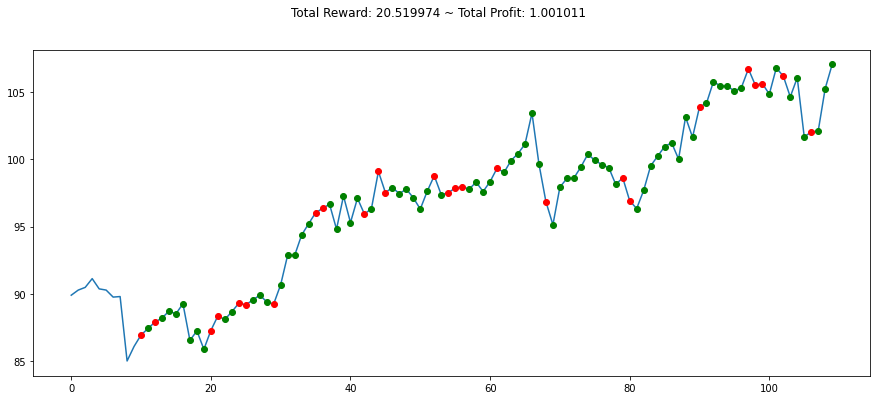

In [188]:
#PPO. 0.76 at 25k 

draw_fig(ppo_model)

info {'total_reward': 22.820030212402344, 'total_profit': 0.918245399835924, 'position': 0}


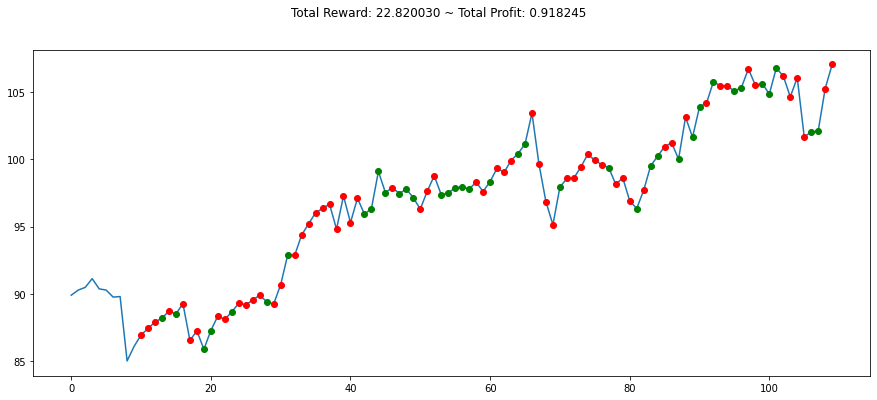

In [193]:
#a2c. 0.86 at 25k
draw_fig(a2c_model)

### DDPG